# Stats of Extreme Events

https://scia.isprambiente.it/

Regione Selezionata: Lazio



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1]:

series = pd.read_csv(
    "/Lazio.csv",
    index_col=2,
    parse_dates=True,
)

NameError: name 'pd' is not defined

In [3]:
print(type(series))
series

<class 'pandas.core.frame.DataFrame'>


,rete,anagrafica,Precipitazioni cumulate
data,,,
1955-01-01,REGIONI - ex SIMN,Stimigliano,3.038
1955-01-02,REGIONI - ex SIMN,Stimigliano,2.170
1955-01-03,REGIONI - ex SIMN,Stimigliano,0.000
1955-01-04,REGIONI - ex SIMN,Stimigliano,0.000
1955-01-05,REGIONI - ex SIMN,Stimigliano,0.000
...,...,...,...
2022-12-27,Regionale ARSIAL Lazio,MONTALTO,0.000
2022-12-28,Regionale ARSIAL Lazio,MONTALTO,0.000
2022-12-29,Regionale ARSIAL Lazio,MONTALTO,0.000


In [4]:
# stampo il primo valore della riga ("data")
series.index[0]

Timestamp('1955-01-01 00:00:00')

In [5]:
print(len(series))

171851


In [6]:
# raggruppo i dati su ogni giorno e considero il massimo
# rimuovo le colonne rete e anagrafica
data = series.groupby(["data"]).max().drop(["rete","anagrafica"], axis=1).squeeze()
data

data
1951-01-01     8.0
1951-01-02     8.4
1951-01-03     9.2
1951-01-04    21.5
1951-01-05     0.0
              ... 
2022-12-27     0.2
2022-12-28     0.0
2022-12-29     0.3
2022-12-30     0.2
2022-12-31     0.0
Name: Precipitazioni cumulate, Length: 26296, dtype: float64

In [7]:
print(len(data))

26296


In [8]:
from pyextremes import EVA

model = EVA(data)

In [9]:
model.get_extremes(method="BM", block_size="365.2425D",errors="coerce")

In [10]:
# Restituisce i valori estremi
print(len(model.extremes))
model.extremes

72


data
1951-09-25    131.600
1952-12-14     65.802
1953-10-27    154.600
1954-11-09     80.992
1955-09-10     82.500
               ...   
2018-10-28    148.000
2019-09-22    206.900
2020-06-05     80.400
2021-12-02     85.000
2022-12-03     93.000
Name: Precipitazioni cumulate, Length: 72, dtype: float64

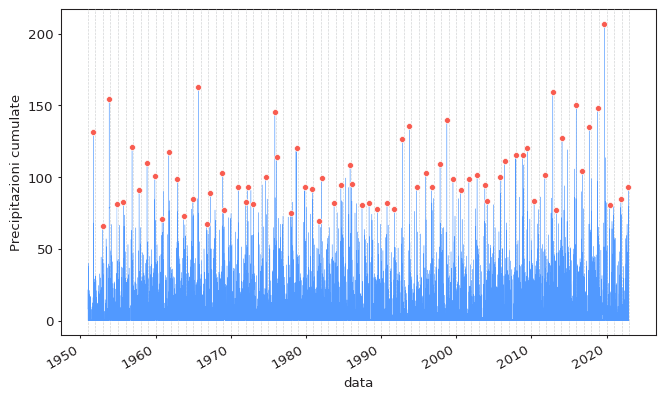

In [11]:
model.plot_extremes()
plt.show()

In [12]:
# Ordino i massimi dal più grande al più piccolo
model.extremes.sort_values(ascending=False)

data
2019-09-22    206.900
1965-09-02    163.074
2012-11-11    159.000
1953-10-27    154.600
2015-12-21    150.100
               ...   
1963-10-04     73.000
1960-11-12     70.538
1981-09-28     69.200
1966-10-12     67.200
1952-12-14     65.802
Name: Precipitazioni cumulate, Length: 72, dtype: float64

In [13]:
# Ottimizzazione della likelihood con il metodo Akaike Information Criterion (AIC)
model.fit_model()


In [14]:
# Stima dei valori attesi tra 1, 2, 5 e 10 anni
summary = model.get_summary(
    return_period=[1, 2, 5, 10],
    alpha=0.95, # intervallo di confidenza
    n_samples=1000, # campioni utilizzati per la stima
)

C:\Users\matte\AppData\Roaming\JetBrains\DataSpell2024.3\projects\workspace\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [15]:
summary

,return value,lower ci,upper ci
return period,,,
1.0,-inf,NaN,NaN
2.0,98.245169,92.884451,104.560328
5.0,119.497062,110.575716,129.219087
10.0,133.567664,121.911695,145.934203


## Empirical Return Periods

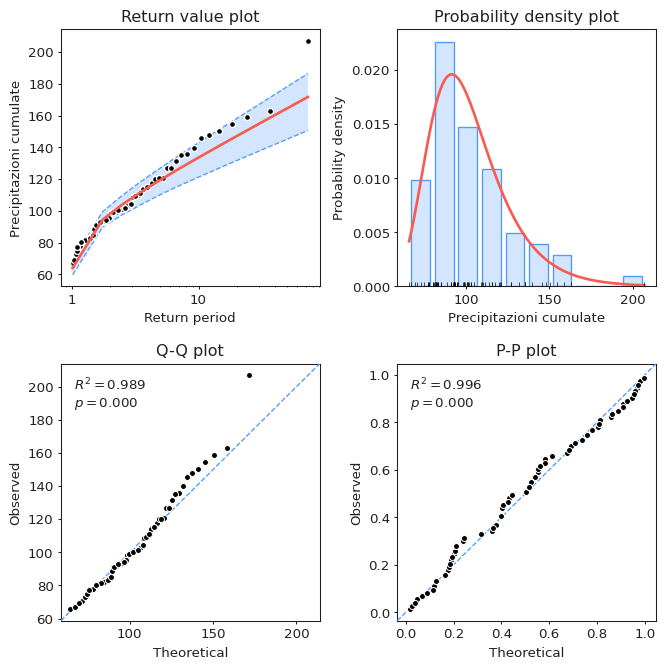

In [16]:
# Genera dei grafici sul periodo di ritorno, sulla densità di probabilità

model.plot_diagnostic(alpha=0.95)
plt.show()

In [17]:
# Distribuzione genextreme (GEV)
# parametri: c è ξ (forma, < 0 è Weibull) loc è μ (posizione), scale è σ (dispersione)
print(model.distribution)

         pyextremes distribution         
-----------------------------------------
name: gumbel_r                           
free parameters: loc, scale              
fixed parameters: all parameters are free
MLE parameters: loc=91.373, scale=18.750 
-----------------------------------------


## Estimating Return Periods

In [18]:
from pyextremes import get_return_periods

return_periods = get_return_periods(
    ts=data,
    extremes=model.extremes,
    extremes_method="BM",
    extremes_type="high",
    block_size="365.2425D",
    return_period_size="365.2425D"
)
return_periods.sort_values("return period", ascending=False).head(10)

,Precipitazioni cumulate,exceedance probability,return period
data,,,
2019-09-22,206.900,0.013699,73.000000
1965-09-02,163.074,0.027397,36.500000
2012-11-11,159.000,0.041096,24.333333
1953-10-27,154.600,0.054795,18.250000
2015-12-21,150.100,0.068493,14.600000
2018-10-28,148.000,0.082192,12.166667
1975-11-17,145.600,0.095890,10.428571
1998-10-06,139.800,0.109589,9.125000
1993-10-02,135.600,0.123288,8.111111


## Peaks Over Threshold

In [19]:
model2 = EVA(data)

model2.get_extremes("POT", threshold=91, r="30D")

#la soglia di 91 è stata decisa facendo dei test ed osservando
# Threshold Selection e facendo delle valutazioni sul diagnosticplot e valutando gli R^2 ed il summary in basso



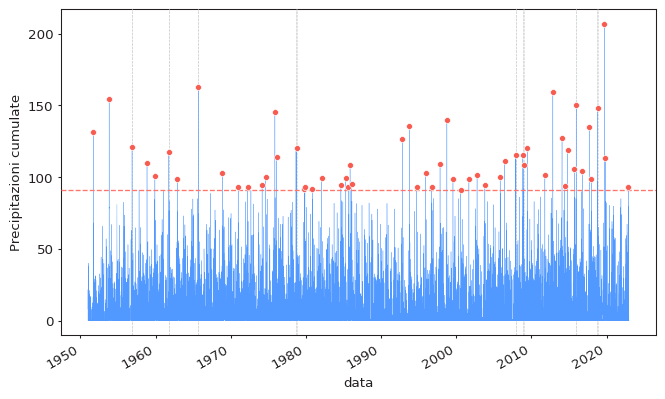

In [20]:
model2.plot_extremes(show_clusters=True)
plt.show()

In [21]:

print(len(model2.extremes))
model2.extremes

57


data
1951-09-25    131.600
1953-10-27    154.600
1956-11-13    120.800
1958-11-11    110.000
1959-11-29    101.100
1961-10-07    117.448
1962-11-29     98.400
1965-09-02    163.074
1968-11-18    103.000
1970-12-27     93.158
1972-03-31     93.000
1974-03-05     94.600
1974-09-01    100.400
1975-11-17    145.600
1976-02-15    113.800
1978-10-02    120.000
1979-10-12     91.500
1979-11-15     93.338
1980-11-13     91.958
1982-02-06     99.600
1984-08-29     94.600
1985-04-26     99.400
1985-08-26     92.800
1985-11-17    108.758
1986-01-31     95.400
1992-11-02    126.800
1993-10-02    135.600
1994-10-02     93.000
1995-12-06    102.800
1996-09-19     93.000
1997-11-07    109.400
1998-10-06    139.800
1999-07-28     99.000
2000-08-05     91.200
2001-09-10     99.000
2002-10-11    101.200
2003-10-26     94.400
2005-11-06    100.400
2006-06-06    111.300
2007-11-29    115.300
2008-11-01    115.300
2008-12-25    108.500
2009-06-21    120.400
2011-10-20    101.600
2012-11-11    159.000
2014-

In [22]:
# Ordino i massimi dal più grande al più piccolo
model2.extremes.sort_values(ascending=False)

data
2019-09-22    206.900
1965-09-02    163.074
2012-11-11    159.000
1953-10-27    154.600
2015-12-21    150.100
2018-10-28    148.000
1975-11-17    145.600
1998-10-06    139.800
1993-10-02    135.600
2017-09-10    135.200
1951-09-25    131.600
2014-01-31    127.000
1992-11-02    126.800
1956-11-13    120.800
2009-06-21    120.400
1978-10-02    120.000
2014-11-07    119.100
1961-10-07    117.448
2007-11-29    115.300
2008-11-01    115.300
1976-02-15    113.800
2019-11-03    113.600
2006-06-06    111.300
1958-11-11    110.000
1997-11-07    109.400
1985-11-17    108.758
2008-12-25    108.500
2015-09-13    105.700
2016-10-06    104.600
1968-11-18    103.000
1995-12-06    102.800
2011-10-20    101.600
2002-10-11    101.200
1959-11-29    101.100
1974-09-01    100.400
2005-11-06    100.400
1982-02-06     99.600
1985-04-26     99.400
2017-12-27     99.000
2001-09-10     99.000
1999-07-28     99.000
1962-11-29     98.400
1986-01-31     95.400
1974-03-05     94.600
1984-08-29     94.600
2003-

In [23]:
# Ottimizzazione della likelihood specificando di utilizzare la distribuzione GPD

model2.fit_model(distribution="genpareto", distribution_kwargs={})

In [24]:
# Stima dei valori attesi tra 1, 2, 5 e 10 anni
# Nota: tempo di esecuzione di circa 2 minuti
summary2 = model2.get_summary(
    return_period=[1, 2, 5, 10],
    alpha=0.95, # intervallo di confidenza
    n_samples=1000, # campioni utilizzati per la stima
)

C:\Users\matte\AppData\Roaming\JetBrains\DataSpell2024.3\projects\workspace\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [25]:
summary2

,return value,lower ci,upper ci
return period,,,
1.0,-inf,NaN,NaN
2.0,105.007651,70.912676,131.025729
5.0,128.247874,116.452651,175.030514
10.0,142.577391,129.936936,191.569490


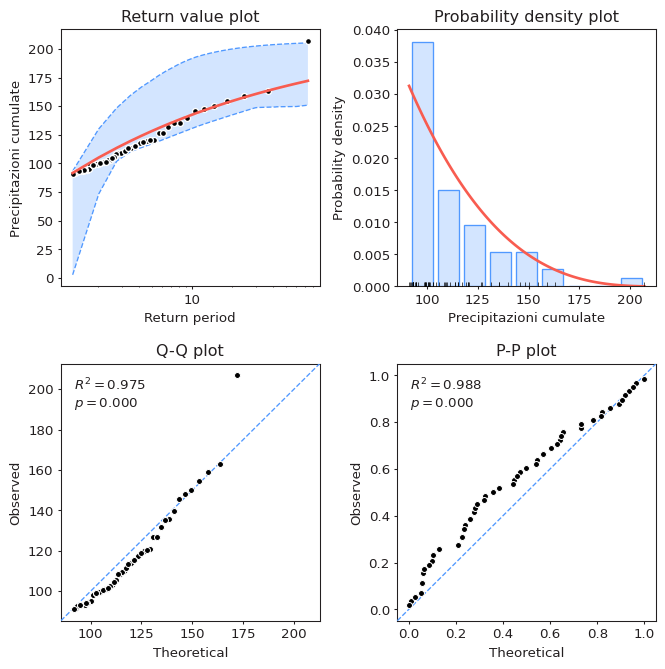

In [26]:
model2.plot_diagnostic(alpha=0.95)
plt.show()

##Questi R^2 sono stati ottenuti eseguendo una selezione della soglia, tramite algoritmi, e testando quale di questi forniva una miglior rappresentazione Q-Q e P-P plot. Soglia selezionata 91

In [27]:
# Distribuzione genpareto (GPD)
# parametri: c è ξ (forma) loc è μ (posizione), scale è σ (scala)
model2.distribution

             pyextremes distribution              
--------------------------------------------------
name: genpareto                                   
free parameters: c, loc, scale                    
fixed parameters: all parameters are free         
MLE parameters: c=-0.253, loc=91.160, scale=31.918
--------------------------------------------------

## Threshold Selection

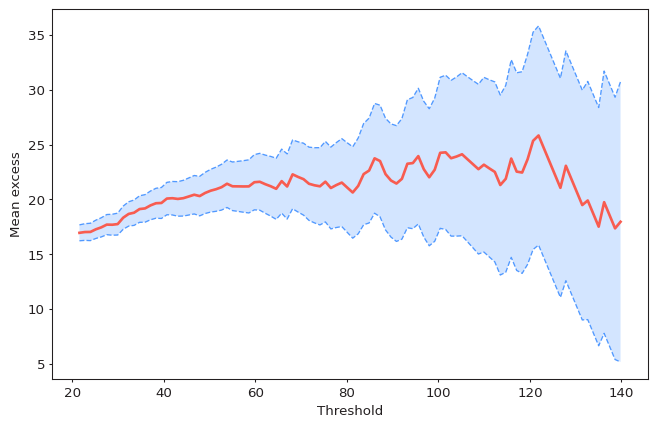

In [28]:
# Mean Residual Life
# informazioni: https://georgebv.github.io/pyextremes/user-guide/5-threshold-selection/#mean-residual-life
from pyextremes import plot_mean_residual_life

plot_mean_residual_life(data)
plt.show()

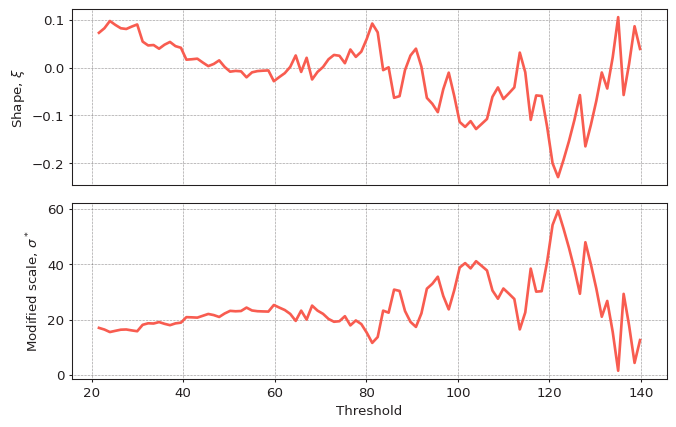

In [29]:
# Parameter Stability
# informazioni: https://georgebv.github.io/pyextremes/user-guide/5-threshold-selection/#parameter-stability
from pyextremes import plot_parameter_stability

plot_parameter_stability(data)
plt.show()

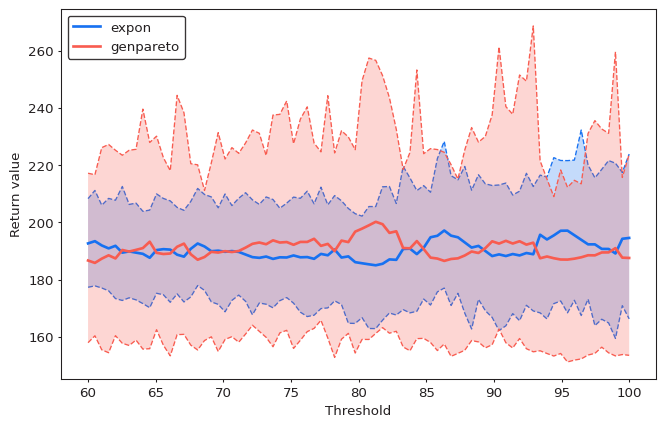

In [30]:
#Return Value Stability
# informazioni: https://georgebv.github.io/pyextremes/user-guide/5-threshold-selection/#return-value-stability
from pyextremes import plot_return_value_stability
import numpy as np

plot_return_value_stability(
    data,
    return_period=100,
    thresholds=np.linspace(60, 100, 80),
    alpha=0.95,
)
plt.show()

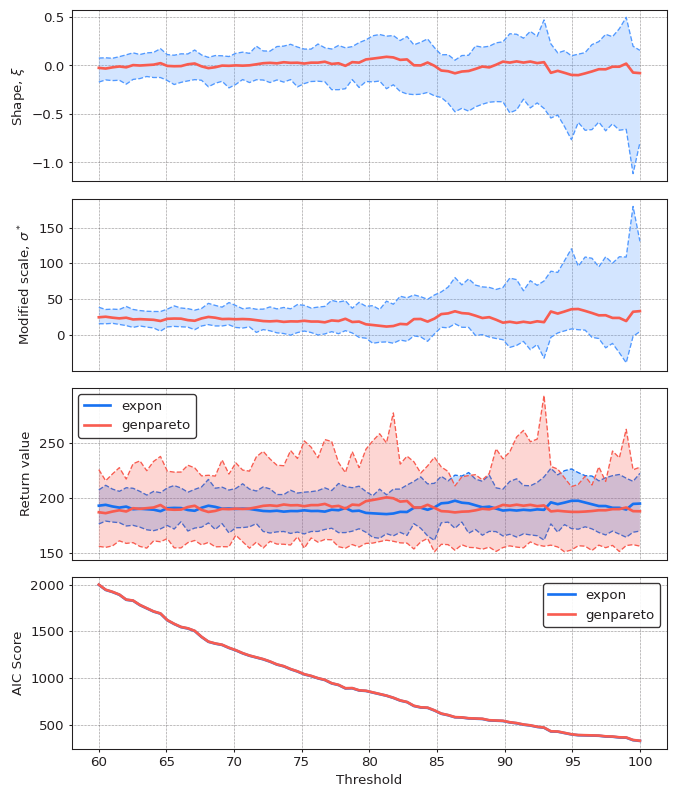

In [31]:
# Tutti i metodi insieme
from pyextremes import plot_threshold_stability

plot_threshold_stability(
    data,
    return_period=100,
    thresholds=np.linspace(60, 100, 80),
    alpha=0.95
)
plt.show()

## Metodo di selezione Basato su R^2 PP QQ

In [32]:
##Funzione per estrazione R^2

import re

def extract_r2_from_diagnostic(model):
    """
    Estrae i valori numerici di R² (QQ e PP) dai plot generati da pyextremes.plot_diagnostic,
    SENZA visualizzare nulla.

    Parametri:
        model: oggetto ThresholdModel già fittato (pyextremes)

    Ritorna:
        r2_qq (float): valore R² del QQ plot
        r2_pp (float): valore R² del PP plot
    """
    # Genera i plot (senza mostrarli)
    fig, (ax_rv, ax_pdf, ax_qq, ax_pp) = model.plot_diagnostic(alpha=0.95)
    fig.canvas.draw()  # forza il rendering per popolare ax.texts

    def get_r2_from_ax(ax):
        for txt in ax.texts:
            content = txt.get_text()
            match = re.search(r"R\^?2\s*=\s*([0-9.]+)", content)
            if match:
                return float(match.group(1))
        return float("nan")

    r2_qq = get_r2_from_ax(ax_qq)
    r2_pp = get_r2_from_ax(ax_pp)

    plt.close(fig)  # evita visualizzazione
    return r2_qq, r2_pp


## Procediamo all'identificazione della migliore soglia

In [33]:

import pandas as pd


best_qq = {"threshold": None, "r2": -1}
best_pp = {"threshold": None, "r2": -1}
results = []  # lista per salvare ogni soglia e R² associati

for n in range(80, 111):
    try:
        model2.get_extremes("POT", threshold=n, r="30D")
        model2.fit_model(distribution="genpareto", distribution_kwargs={})

        r2_qq, r2_pp = extract_r2_from_diagnostic(model2)
        print(f"Soglia {n} → R² QQ: {r2_qq:.4f}, R² PP: {r2_pp:.4f}")

        results.append({
            "threshold": n,
            "r2_qq": r2_qq,
            "r2_pp": r2_pp
        })

        if r2_qq > best_qq["r2"]:
            best_qq = {"threshold": n, "r2": r2_qq}
        if r2_pp > best_pp["r2"]:
            best_pp = {"threshold": n, "r2": r2_pp}

    except Exception as e:
        print(f" Errore alla soglia {n}: {e}")

# Risultati finali
print("\n Miglior R² QQ:")
print(f"Soglia: {best_qq['threshold']}, R² QQ: {best_qq['r2']:.4f}")

print("\n Miglior R² PP:")
print(f"Soglia: {best_pp['threshold']}, R² PP: {best_pp['r2']:.4f}")

# DataFrame con tutti i risultati
df_results = pd.DataFrame(results)
df_sorted = df_results.sort_values(by="r2_pp", ascending=False)

print("\n Top soglie ordinate per R² PP:")
print(df_sorted.head(5).to_string(index=False))


Soglia 80 → R² QQ: 0.9040, R² PP: 0.9030
Soglia 81 → R² QQ: 0.9950, R² PP: 0.9970
Soglia 82 → R² QQ: 0.9930, R² PP: 0.9970
Soglia 83 → R² QQ: 0.9630, R² PP: 0.9730
Soglia 84 → R² QQ: 0.9930, R² PP: 0.9960
Soglia 85 → R² QQ: 0.9940, R² PP: 0.9950
Soglia 86 → R² QQ: 0.9940, R² PP: 0.9950
Soglia 87 → R² QQ: 0.9920, R² PP: 0.9960
Soglia 88 → R² QQ: 0.9920, R² PP: 0.9960
Soglia 89 → R² QQ: 0.9800, R² PP: 0.9930
Soglia 90 → R² QQ: 0.9800, R² PP: 0.9930
Soglia 91 → R² QQ: 0.9750, R² PP: 0.9880
Soglia 92 → R² QQ: 0.9270, R² PP: 0.9320
Soglia 93 → R² QQ: 0.9140, R² PP: 0.9190
Soglia 94 → R² QQ: 0.8820, R² PP: 0.8810
Soglia 95 → R² QQ: 0.8780, R² PP: 0.8750
Soglia 96 → R² QQ: 0.8760, R² PP: 0.8730
Soglia 97 → R² QQ: 0.8760, R² PP: 0.8730
Soglia 98 → R² QQ: 0.8760, R² PP: 0.8730
Soglia 99 → R² QQ: 0.8820, R² PP: 0.8780
Soglia 100 → R² QQ: 0.8790, R² PP: 0.8720
Soglia 101 → R² QQ: 0.8750, R² PP: 0.8640
Soglia 102 → R² QQ: 0.8790, R² PP: 0.8690
Soglia 103 → R² QQ: 0.8630, R² PP: 0.8470
Soglia 104 →

# Dopo aver identificato la soglia migliore plottiamo ed analizziamo il risultato

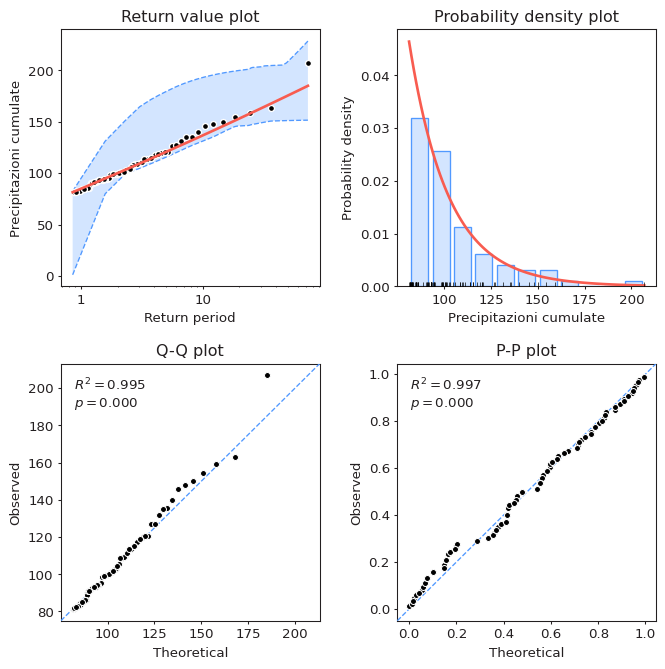

In [34]:
model2.get_extremes("POT", threshold=81, r="30D")
model2.fit_model(distribution="genpareto", distribution_kwargs={})
model2.plot_diagnostic(alpha=0.95)
plt.show()

In [35]:
model2.distribution

             pyextremes distribution             
-------------------------------------------------
name: genpareto                                  
free parameters: c, loc, scale                   
fixed parameters: all parameters are free        
MLE parameters: c=0.034, loc=81.314, scale=21.540
-------------------------------------------------

In [36]:
summary3 = model2.get_summary(
    return_period=[1, 2, 5, 10],
    alpha=0.95, # intervallo di confidenza
    n_samples=1000, # campioni utilizzati per la stima
)

In [37]:
summary3

,return value,lower ci,upper ci
return period,,,
1.0,84.900362,26.588246,97.558402
2.0,100.095774,96.051038,145.630888
5.0,120.745408,114.490171,179.238159
10.0,136.803033,128.437624,193.352860


# 📊 Considerazioni Quantitative dai Risultati del Progetto Finale 2

Il progetto finale 2 applica i concetti dell'Extreme Value Theory (EVT) ai dati di precipitazione giornaliera per la regione Lazio, dal 1951 al 2022 (per un totale di 26.296 giorni).

---

## 1. Analisi Block Maxima (BM)

- Sono stati estratti i **massimi annuali** utilizzando un blocco di dimensione 365 giorni. Il dataset ha prodotto **72 massimi annuali**.
- Questa è una quantità ragionevole di punti per adattare un modello **GEV/Gumbel**.

### 📈 Stime dei valori di ritorno (IC 95%):
- 2 anni: **98.245 mm** (IC: 92.884 - 104.560 mm)
- 5 anni: **119.497 mm** (IC: 110.575 - 129.219 mm)
- 10 anni: **133.568 mm** (IC: 121.912 - 145.934 mm)

- Il valore di ritorno stimato per 1 anno è **-inf** con intervallo di confidenza **NaN**: ciò può indicare un’inadeguatezza del modello Gumbel per periodi così brevi o un problema numerico.
- L’evento massimo osservato nel dataset (206.9 mm il 22-09-2019) ha un periodo di ritorno empirico di circa **73 anni**, ben superiore ai 10 anni stimati dal modello → evento estremamente raro.

---

## 2. Analisi Peaks Over Threshold (POT)

- È stato scelto un parametro di **declustering** `r = 30D`.
- La scelta della soglia è stata studiata. Inizialmente è stata fissata a **91 mm**, individuando **57 eventi estremi**.

### 📈 Parametri MLE del modello GPD (soglia 91 mm):
- `c = -0.253`, `loc = 91.160`, `scale = 31.918`
- Il parametro di forma negativo (`c < 0`) indica una distribuzione di tipo **Weibull** per gli eccessi.

### 📈 Valori di ritorno (IC 95%):
- 2 anni: **105.008 mm** (IC: 70.913 - 131.026 mm)
- 5 anni: **128.248 mm** (IC: 116.453 - 175.031 mm)
- 10 anni: **142.577 mm** (IC: 129.937 - 191.569 mm)

- Anche qui, il valore stimato per 1 anno è **-inf**.

---

## 🔍 Ricerca della soglia ottimale

- È stata condotta una ricerca per valori di soglia da **80 a 110 mm**, valutando la bontà di adattamento tramite gli **R²** dei plot **Q-Q** e **P-P**.
- I valori numerici di R² sono stati **estratti automaticamente** dai plot diagnostici, poiché non forniti direttamente dalla libreria `pyextremes`.

### 📊 Alcuni esempi di risultati R²:
- Soglia **81** → QQ: **0.9950**, PP: **0.9970**
- Soglia **84** → QQ: **0.9930**, PP: **0.9960**
- Soglia **88** → QQ: **0.9920**, PP: **0.9960**

➡️ La soglia **81 mm** ha fornito i valori **più alti di R²** → selezionata per l’analisi finale.

---

## 3. Analisi POT finale (soglia ottimale = 81 mm)

### 📈 Parametri GPD:
- `c = 0.034`, `loc = 81.314`, `scale = 21.540`
- Il parametro di forma positivo ma molto vicino a 0 → distribuzione simile a quella **esponenziale**.

### 📈 Valori di ritorno stimati (IC 95%):
- 1 anno: **84.900 mm** (IC: 26.588 - 97.558 mm)
- 2 anni: **100.096 mm** (IC: 96.051 - 145.631 mm)
- 5 anni: **120.745 mm** (IC: 114.490 - 179.238 mm)
- 10 anni: **136.803 mm** (IC: 128.438 - 193.353 mm)

---

## 🔁 Confronto e Conclusioni

### 💧 Valori di ritorno coerenti tra BM e POT:
- 5 anni → BM: **119.5 mm** | POT: **120.7 mm**
- 10 anni → BM: **133.6 mm** | POT: **136.8 mm**

Le differenze sono **modeste**, considerando l’ampiezza degli intervalli di confidenza.

---

### 📈 Bontà di Stima (Fit dei Modelli):

- I **plot Q-Q e P-P** sono stati generati per tutti i modelli (BM e POT con soglie 91 e 81).
- L’allineamento dei punti lungo la diagonale nei plot indica un buon fit.
- Il progetto ha **quantificato la bontà del fit** con R², superando 0.99 per le soglie migliori.
- Questo supporta numericamente ciò che già si osservava visivamente.

---

### ✅ Conclusione

Entrambi i modelli EVT — **BM con GEV** e **POT con GPD (soglia 81 mm)** — forniscono stime **coerenti e affidabili** per eventi estremi nella regione Lazio.

L’aggiunta della valutazione quantitativa tramite **R²** ha permesso di rafforzare l’analisi, rendendo il processo di selezione della soglia **rigoroso e giustificabile**.
